In [18]:
import pandas as pd
import numpy as np
print(f'Panda version: {pd.__version__}')
print(f'Numpy version: {np.__version__}')

Panda version: 1.5.3
Numpy version: 1.23.1


# Sandbox

## Download NY street data
https://gis.ny.gov/system/files/documents/2023/03/how-to-create-county-filters-of-nys-address-point-data.pdf

## Discussion
Seq to Seq model. ~~Input and Output will both have length of 6~~

## Quesiton 1
1. ~~How to write the encoding and padding for each sub-component? Maybe don't need. I think Seq can take a whole Seq as an input and output another Seq~~
2. When inference, can we run different tokens with the next likelihood, so that we can list out 5 predictions with their relative order?

In [94]:
addr = pd.read_csv('Datasets/NYS_Address_Points.csv')

KeyboardInterrupt: 

In [ ]:
addr.columns

Index(['OBJECTID', 'NYSAddressPointID', 'CountyID', 'NYSStreetID',
       'PrefixAddressNumber', 'AddressNumber', 'SuffixAddressNumber',
       'PreModifier', 'PreDirectional', 'PreType', 'SeparatorElement',
       'StreetName', 'PostType', 'PostDirectional', 'PostModifier',
       'SubAddress', 'Structure', 'Floor', 'Unit', 'Location', 'Site',
       'SubSite', 'BusinessName', 'ZipName', 'State', 'ZipCode', 'PointType',
       'AddressSource', 'DiscrepancyAgencyID', 'DateUpdated', 'PrimaryPoint',
       'CityTownName', 'PlaceName', 'PlaceType', 'CompleteStreetName',
       'AP_Flag', 'Status', 'AddressLabel', 'CountyName',
       'CLDXF_PreDirectional', 'CLDXF_PostType', 'CLDXF_PostDirectional',
       'Country', 'ESN', 'IncorporatedMunicipality',
       'UnincorporatedMunicipality', 'NeighborhoodCommunity',
       'MSAGCommunityName', 'MilePost', 'SWIS_SBL_ID', 'SWIS_PRINT_KEY_ID',
       'MunicipalityType', 'AddressType', 'USERNAME', 'CR_USERNAME',
       'CR_DATETIME', 'AT_USERNAME

In [ ]:
addr[['AddressNumber','StreetName','PostType','CountyName','CityTownName','ZipCode','State']].head()

,AddressNumber,StreetName,PostType,CountyName,CityTownName,ZipCode,State
0,519,Wolf Run,Rd,Cattaraugus,Coldspring,14779.0,NY
1,584,Wolf Run,Rd,Cattaraugus,Coldspring,14779.0,NY
2,589,Wolf Run,Rd,Cattaraugus,Coldspring,14779.0,NY
3,557,23,NaN,Cattaraugus,Coldspring,14779.0,NY
4,397,280,NaN,Cattaraugus,South Valley,14779.0,NY


In [25]:
addr['ZipName'].value_counts().head(20)

Buffalo          331767
Brooklyn         308882
Rochester        267913
Staten Island    129677
Syracuse         108095
Bronx            105995
Albany            94485
Schenectady       72789
Yonkers           67842
New York          62473
Binghamton        44513
Poughkeepsie      42436
Niagara Falls     41064
Ithaca            39302
Troy              37996
Jamaica           36382
White Plains      30314
Flushing          29999
Middletown        29875
Lockport          29259
Name: ZipName, dtype: int64

In [ ]:
addr.sample(5).to_excel('Datasets/NYS_sample.xlsx')

In [27]:
addr_debug = addr.loc[lambda x:x['CityTownName'] == 'New York'][['AddressNumber','StreetName','PostType','CountyName','CityTownName','ZipName','ZipCode','State']].copy()
addr_debug.dropna(inplace = True)
addr_debug.drop_duplicates(inplace = True)
addr_debug.to_parquet('Datasets/NYS_clean.parquet.gz')

In [57]:
addr_debug = pd.read_parquet('Datasets/NYS_clean.parquet.gz', engine='pyarrow')

In [60]:
addr_debug[['CountyName','ZipName']].drop_duplicates().value_counts().to_frame()

0
CountyName  ZipName           
Bronx       Bronx            1
Queens      Jackson Heights  1
            Kew Gardens      1
            Lawrence         1
            Little Neck      1
...                         ..
            Flushing         1
            Forest Hills     1
            Fresh Meadows    1
            Glen Oaks        1
Westchester Yonkers          1

[61 rows x 1 columns]

In [96]:
addr_debug.sample(5)

,AddressNumber,StreetName,PostType,CountyName,CityTownName,ZipName,ZipCode,State
5686141,486,Sea Breeze,Walk,Queens,New York,Breezy Point,11697.0,NY
5259547,3014,Lafayette,Ave,Bronx,New York,Bronx,10465.0,NY
5685070,10,Thetford,Ln,Queens,New York,Breezy Point,11697.0,NY
5261381,529,Brush,Ave,Bronx,New York,Bronx,10465.0,NY
5855354,718,Oakland,Ave,Richmond,New York,Staten Island,10310.0,NY


In [111]:
import random
toy = addr_debug.sample(5)
toy[['AddressNumber','StreetName','PostType','ZipName','State','ZipCode']].astype(str).apply(lambda x:','.join(x), axis = 1).apply(lambda x:x.split(','))

5753496                [2055, 73, St, Brooklyn, NY, 11204.0]
5793793                [5306, 8, Ave, Brooklyn, NY, 11220.0]
5791718               [5104, 10, Ave, Brooklyn, NY, 11219.0]
5869847    [421, Father Capodanno, Blvd, Staten Island, N...
5851025        [445, Ocean, Ter, Staten Island, NY, 10301.0]
dtype: object

In [113]:
def order_random_sample(myList,K):
    indices = random.sample(range(len(myList)), K)
    return [myList[i] for i in sorted(indices)]

toy[['AddressNumber','StreetName','PostType','ZipName','State','ZipCode']].astype(str).apply(lambda x:','.join(x), axis = 1).apply(lambda x:x.split(',')).apply(lambda x:order_random_sample(x,4))

5753496                        [73, St, Brooklyn, 11204.0]
5793793                      [5306, Brooklyn, NY, 11220.0]
5791718                       [Ave, Brooklyn, NY, 11219.0]
5869847    [421, Father Capodanno, Staten Island, 10305.0]
5851025                      [445, Ter, Staten Island, NY]
dtype: object

In [32]:
for col_i in addr_debug.columns:
    print(f'{col_i} has max length of {addr_debug[col_i].astype(str).apply(len).max()}')

AddressNumber has max length of 5
StreetName has max length of 28
PostType has max length of 6
CountyName has max length of 11
CityTownName has max length of 8
ZipName has max length of 19
ZipCode has max length of 7
State has max length of 2


In [36]:
addr_debug.loc[:,lambda x:x.columns.isin(['AddressNumber'])]

,AddressNumber
4303742,210
4303743,208
4303744,201
4303745,208
4303748,209
...,...
5942778,25
5942779,405
5942780,17
5942781,397


In [97]:
import random
def order_random_sample(myList,K,lb=2):
    indices = random.sample(range(len(myList)-lb), K)
    indices = [x+lb for x in indices]
    return [myList[i] for i in sorted(indices)]

order_random_sample([1,2,3,4,5,6,7,8],4)

[4, 6, 7, 8]

# Dataset Ingest Starts from Here

In [141]:
import pandas as pd
import numpy as np
print(f'Panda version: {pd.__version__}')
print(f'Numpy version: {np.__version__}')
import utils
from importlib import reload
utils = reload(utils)

Panda version: 1.5.3
Numpy version: 1.23.1


In [142]:
context_raw,target_raw = utils.create_label_target('Datasets/NYS_clean.parquet.gz')
print(f'Context shape: {context_raw.shape}')
print(f'Target shape: {target_raw.shape}')

Context shape: (2000000,)
Target shape: (2000000,)


In [145]:
random_numbers = np.random.choice(len(context_raw), 1)[0]
context_raw[random_numbers],target_raw[random_numbers]

('410 182 St Bronx NY', '410 182 St Bronx Bronx NY 10457')

# Re-load Data

In [146]:
np.save("context_raw.npy", context_raw)
np.save("target_raw.npy", target_raw)

In [ ]:
context_raw = np.load("context_raw.npy")
target_raw = np.load("target_raw.npy")

In [ ]:
import h5py
# Output to HDF5 file
f = h5py.File("context_raw.h5", "w")
f["array"] = context_raw
f.close()

f = h5py.File("target_raw.h5", "w")
f["array"] = target_raw
f.close()

In [ ]:
# Open the HDF5 file
f = h5py.File("context_raw.h5", "r")
context_raw = f["array"]
f.close()

f = h5py.File("target_raw.h5", "r")
target_raw = f["array"]
f.close()

# Data Processing

In [147]:
import tensorflow as tf
import tensorflow_text as tf_text

BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [148]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'319 Colon Staten Island NY 10308' b'150 Nichols Ave Kings 11208'
 b'20 Liberty Ave Queens 11435' b'274 Madison Ave New York New York'
 b'85 Wetherole St Rego Park Queens'], shape=(5,), dtype=string)

tf.Tensor(
[b'319 Colon Ave Staten Island Richmond NY 10308'
 b'150 Nichols Ave Brooklyn Kings NY 11208'
 b'20 Liberty Ave Jamaica Queens NY 11435'
 b'274 Madison Ave New York New York NY 10016'
 b'85 Wetherole St Rego Park Queens NY 11374'], shape=(5,), dtype=string)


In [149]:
import utils
from importlib import reload
utils = reload(utils)

example_text = tf.constant('18 Hartford Richmond Staten Island NY 10308')
print(example_text.numpy().decode())
print(utils.tf_lower_and_split_punct(example_text).numpy().decode())

18 Hartford Richmond Staten Island NY 10308
[START] 18 hartford richmond staten island ny 10308 [END]


# Text Vectorization

In [150]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=utils.tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [151]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

['',
 '[UNK]',
 '[START]',
 '[END]',
 'ny',
 'st',
 'kings',
 'brooklyn',
 'ave',
 'bronx']

In [152]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=utils.tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['',
 '[UNK]',
 'ny',
 '[START]',
 '[END]',
 'st',
 'kings',
 'brooklyn',
 'ave',
 'bronx']

In [153]:
print(example_context_strings)
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

tf.Tensor(
[b'319 Colon Staten Island NY 10308' b'150 Nichols Ave Kings 11208'
 b'20 Liberty Ave Queens 11435' b'274 Madison Ave New York New York'
 b'85 Wetherole St Rego Park Queens' b'76 Marshall Ave Richmond 10314'
 b'3234 Corsa Ave Bronx 10469' b'937 156 St Bronx 10455'
 b'883 Wyckoff Queens NY 11385' b'14 Morrison Ave NY 10310'
 b'2048 86 St Kings 11214' b'65 Mada Ave Staten Island 10310'
 b'1076 Bergen Ave Brooklyn 11234' b'2513 64 Brooklyn NY 11234'
 b'35 Stuyvesant St NY 10003' b'531 Grassmere Far Rockaway Queens NY'
 b'61 76 St Ozone Park Queens' b'195 Rochester Ave Brooklyn Kings'
 b'123 Perry Ave Staten Island 10314'
 b'121 Heberton Staten Island Richmond 10302'
 b'17 Dulancey Ct Richmond NY' b'740 51 Kings NY 11220'
 b'74 Wolverine Richmond NY 10306' b'50 Court St Brooklyn Kings'
 b'59 Shepherd Ave Brooklyn NY' b'4 59 Queens NY 11362'
 b'1045 St Johns Pl Brooklyn Kings' b'1 Cedarview Ave Richmond NY'
 b'1647 Glenwood Rd NY 11230' b'4361 Richardson Ave Bronx NY'
 b'6309 23 

<tf.RaggedTensor [[2, 708, 1269, 13, 12, 4, 101, 3], [2, 293, 1450, 8, 6, 39, 3],
 [2, 51, 513, 8, 10, 213, 3]]>

In [154]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] 319 colon staten island ny 10308 [END]'

# Process Text

In [155]:
def process_text(context, target):
    context = context_text_processor(context).to_tensor()
    target = target_text_processor(target)
    targ_in = target[:,:-1].to_tensor()
    targ_out = target[:,1:].to_tensor()
    return (context, targ_in), targ_out

In [156]:
train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
    print(ex_context_tok[0, :10].numpy()) 
    print()
    print(ex_tar_in[0, :10].numpy()) 
    print(ex_tar_out[0, :10].numpy())

[   2 2065  754    8    9  249    3    0    0]

[   3 2065  762    8    9    9    2  224    0    0]
[2065  762    8    9    9    2  224    4    0    0]


# Encoder

In [157]:
UNITS = 256
class Encoder(tf.keras.layers.Layer):
    def __init__(self, text_processor, units):
        super(Encoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.units = units

        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, units, mask_zero=True)

        # The RNN layer processes those vectors sequentially.
        self.rnn = tf.keras.layers.Bidirectional(
            merge_mode='sum',
            layer=tf.keras.layers.GRU(units,
                                # Return the sequence and state
                                return_sequences=True,
                                recurrent_initializer='glorot_uniform'))

    def call(self, x):
        shape_checker = utils.ShapeChecker()
        shape_checker(x, 'batch s')

        # 2. The embedding layer looks up the embedding vector for each token.
        x = self.embedding(x)
        shape_checker(x, 'batch s units')

        # 3. The GRU processes the sequence of embeddings.
        x = self.rnn(x)
        shape_checker(x, 'batch s units')

        # 4. Returns the new sequence of embeddings.
        return x

    def convert_input(self, texts):
        texts = tf.convert_to_tensor(texts)
        if len(texts.shape) == 0:
          texts = tf.convert_to_tensor(texts)[tf.newaxis]
        context = self.text_processor(texts).to_tensor()
        context = self(context)
        return context

# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 9)
Encoder output, shape (batch, s, units): (64, 9, 256)


In [158]:
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, x, context):
        shape_checker = utils.ShapeChecker()

        shape_checker(x, 'batch t units')
        shape_checker(context, 'batch s units')

        attn_output, attn_scores = self.mha(
            query=x,
            value=context,
            return_attention_scores=True)

        shape_checker(x, 'batch t units')
        shape_checker(attn_scores, 'batch heads t s')

        # Cache the attention scores for plotting later.
        attn_scores = tf.reduce_mean(attn_scores, axis=1)
        shape_checker(attn_scores, 'batch t s')
        self.last_attention_weights = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 9, 256)
Target sequence, shape (batch, t, units): (64, 11, 256)
Attention result, shape (batch, t, units): (64, 11, 256)
Attention weights, shape (batch, t, s):    (64, 11, 9)


In [159]:
class Decoder(tf.keras.layers.Layer):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, text_processor, units):
        super(Decoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.word_to_id = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token='', oov_token='[UNK]')
        self.id_to_word = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token='', oov_token='[UNK]',
            invert=True)
        self.start_token = self.word_to_id('[START]')
        self.end_token = self.word_to_id('[END]')

        self.units = units


        # 1. The embedding layer converts token IDs to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                                units, mask_zero=True)

        # 2. The RNN keeps track of what's been generated so far.
        self.rnn = tf.keras.layers.GRU(units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')

        # 3. The RNN output will be the query for the attention layer.
        self.attention = CrossAttention(units)

        # 4. This fully connected layer produces the logits for each
        # output token.
        self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [160]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
    shape_checker = utils.ShapeChecker()
    shape_checker(x, 'batch t')
    shape_checker(context, 'batch s units')

    # 1. Lookup the embeddings
    x = self.embedding(x)
    shape_checker(x, 'batch t units')

    # 2. Process the target sequence.
    x, state = self.rnn(x, initial_state=state)
    shape_checker(x, 'batch t units')

    # 3. Use the RNN output as the query for the attention over the context.
    x = self.attention(x, context)
    self.last_attention_weights = self.attention.last_attention_weights
    shape_checker(x, 'batch t units')
    shape_checker(self.last_attention_weights, 'batch t s')

    # Step 4. Generate logit predictions for the next token.
    logits = self.output_layer(x)
    shape_checker(logits, 'batch t target_vocab_size')

    if return_state:
        return logits, state
    else:
        return logits

In [161]:
decoder = Decoder(target_text_processor, UNITS)

In [162]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 9, 256)
input target tokens shape: (batch, t) (64, 11)
logits shape shape: (batch, target_vocabulary_size) (64, 11, 5000)


In [163]:
# Add method for inference
@Decoder.add_method
def get_initial_state(self, context):
    batch_size = tf.shape(context)[0]
    start_tokens = tf.fill([batch_size, 1], self.start_token)
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    embedded = self.embedding(start_tokens)
    return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

@Decoder.add_method
def tokens_to_text(self, tokens):
    words = self.id_to_word(tokens)
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
    result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
    return result

@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
    logits, state = self(
        context, next_token,
        state = state,
        return_state=True) 

    if temperature == 0.0:
        next_token = tf.argmax(logits, axis=-1)
    else:
        logits = logits[:, -1, :]/temperature
        next_token = tf.random.categorical(logits, num_samples=1)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (next_token == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

    return next_token, done, state

In [164]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
    # Run one step.
    next_token, done, state = decoder.get_next_token(
        ex_context, next_token, done, state, temperature=1.0)
    # Add the token to the output.
    tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'guernsey 1279 321 fort broad 1794 4201 3214 14 empire',
       b'plz major kildare 1099 2158 627 vlg 1316 1290 10455',
       b'2710 rupert 285 palo dunbar 315 861 934 timber webster'],
      dtype=object)

# Model

In [165]:
class Addressor(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, units,
                context_text_processor,
                target_text_processor):
        super().__init__()
        # Build the encoder and decoder
        encoder = Encoder(context_text_processor, units)
        decoder = Decoder(target_text_processor, units)

        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        context, x = inputs
        context = self.encoder(context)
        logits = self.decoder(context, x)

        #TODO(b/250038731): remove this
        try:
            # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
            del logits._keras_mask
        except AttributeError:
            pass

        return logits

In [166]:
model = Addressor(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 9)
Target tokens, shape: (batch, t) (64, 11)
logits, shape: (batch, t, target_vocabulary_size) (64, 11, 5000)


In [167]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [168]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

print(model.summary())

Model: "addressor_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_7 (Encoder)         multiple                  2069504   
                                                                 
 decoder_7 (Decoder)         multiple                  3223432   
                                                                 


Total params: 5,292,936
Trainable params: 5,292,936
Non-trainable params: 0
_________________________________________________________________
None


In [169]:
history = model.fit(
    train_ds.repeat(), 
    epochs=10,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/10
100/100 [==============================] - 98s 859ms/step - loss: 3.5907 - masked_acc: 0.4779 - masked_loss: 3.5907 - val_loss: 2.3613 - val_masked_acc: 0.6104 - val_masked_loss: 2.3613
Epoch 2/10
100/100 [==============================] - 92s 922ms/step - loss: 1.9421 - masked_acc: 0.6735 - masked_loss: 1.9421 - val_loss: 1.3915 - val_masked_acc: 0.7717 - val_masked_loss: 1.3915
Epoch 3/10
100/100 [==============================] - 93s 928ms/step - loss: 1.1028 - masked_acc: 0.8200 - masked_loss: 1.1028 - val_loss: 0.8800 - val_masked_acc: 0.8590 - val_masked_loss: 0.8800
Epoch 4/10
100/100 [==============================] - 97s 970ms/step - loss: 0.7350 - masked_acc: 0.8781 - masked_loss: 0.7350 - val_loss: 0.6206 - val_masked_acc: 0.8928 - val_masked_loss: 0.6206
Epoch 5/10
100/100 [==============================] - 90s 903ms/step - loss: 0.5374 - masked_acc: 0.9059 - masked_loss: 0.5374 - val_loss: 0.4656 - val_masked_acc: 0.9189 - val_masked_loss: 0.4656
Epoch 6/10
100/

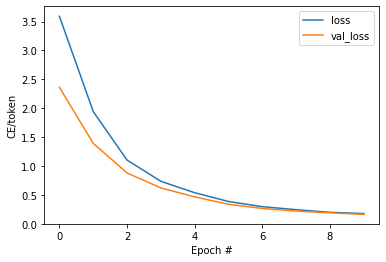

In [170]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

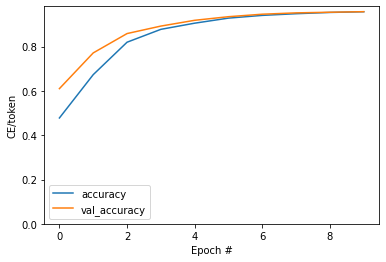

In [171]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [172]:
@Addressor.add_method
def Addressor_fix(self,
                  texts, *,
                  max_length=50,
                  temperature=0.0):
    # Process the input texts
    context = self.encoder.convert_input(texts)
    batch_size = tf.shape(texts)[0]

    # Setup the loop inputs
    tokens = []
    attention_weights = []
    next_token, done, state = self.decoder.get_initial_state(context)

    for _ in range(max_length):
        # Generate the next token
        next_token, done, state = self.decoder.get_next_token(
            context, next_token, done,  state, temperature)

        # Collect the generated tokens
        tokens.append(next_token)
        attention_weights.append(self.decoder.last_attention_weights)

        if tf.executing_eagerly() and tf.reduce_all(done):
            break

    # Stack the lists of tokens and attention weights.
    tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
    self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

    result = self.decoder.tokens_to_text(tokens)
    return result

@Addressor.add_method
def plot_attention(self, text, **kwargs):
    assert isinstance(text, str)
    output = self.Addressor_fix([text], **kwargs)
    output = output[0].numpy().decode()

    attention = self.last_attention_weights[0]

    context = utils.tf_lower_and_split_punct(text)
    context = context.numpy().decode().split()

    output = utils.tf_lower_and_split_punct(output)
    output = output.numpy().decode().split()[1:]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)

    ax.matshow(attention, cmap='viridis', vmin=0.0)

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + output, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.set_xlabel('Input text')
    ax.set_ylabel('Output text')

In [201]:

random_numbers = np.random.choice(len(example_context_strings), 1)[0]

for example_context_strings, example_target_strings in train_raw.take(1):
    print(example_context_strings[random_numbers:random_numbers + 5])
    print()
    print(example_target_strings[random_numbers:random_numbers + 5])
    break

tf.Tensor(
[b'27 Station Rd NY 11358' b'62 Catalpa Ridgewood Queens NY'
 b'275 Sandalwood Dr Staten Island Richmond' b'48 148 Jamaica Queens NY'
 b'437 Zerega Bronx NY 10473'], shape=(5,), dtype=string)

tf.Tensor(
[b'27 Station Rd Flushing Queens NY 11358'
 b'62 Catalpa Ave Ridgewood Queens NY 11385'
 b'275 Sandalwood Dr Staten Island Richmond NY 10308'
 b'48 148 St Jamaica Queens NY 11436'
 b'437 Zerega Ave Bronx Bronx NY 10473'], shape=(5,), dtype=string)


In [210]:
context = '48 148 St Jongololo Queens NY 11436'
result = model.Addressor_fix([context]) 
result

<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'48 148 st jamaica queens ny 11436 '], dtype=object)>

In [ ]:
model.plot_attention(context)

# Output

In [191]:
class Export(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
    def Addressor_fix(self, inputs):
        return self.model.Addressor_fix(inputs)

In [192]:
export = Export(model)

_ = export.Addressor_fix(tf.constant(inputs))

NameError: name 'inputs' is not defined

In [193]:
tf.saved_model.save(export, 'Addressor_fix',
                    signatures={'serving_default': export.Addressor_fix})

INFO:tensorflow:Assets written to: Addressor_fix\assets


INFO:tensorflow:Assets written to: Addressor_fix\assets
